# Trabalho avaliativo I

## Este trabalho visa o desenvolvimento de classificadores a partir de dois conjuntos de dados bem conhecidos no ramo. O conjunto de dados `Iris` e o conjunto `MNIST`

Para a primeira parte serão usados dois classificadores. O primeiro composto por dois classificadores de regressão logistica. Cada um responsável pelo reconhecimento de uma classe e a terceira obtida por exclusão. O segundo será composto por um classificador de regressão logística para cada classe.

Para a segunda parte serão usados o método `OneVsAll` e `Multilayer` perceptron.

O Objetivo da utilização de dois classificadores para cada conjunto de dados é de alcançar a melhor classificação possível e discutir os prós e contras de cada implementação.

Para a validação será usado o método `Holdout`, separando $\frac{2}{3}$ do conjunto de dados para treinamento e $\frac{1}{3}$ para validação. Já para analise de desempenho do modelo serão usadas `Precisão` e `Acurácia total`.

### Nota: python packages em ../requirements.txt

In [1]:
# used for manipulating directory paths
import os

#Scientific and vector computadion form python
import numpy as np

#Plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random
import seaborn
seaborn.set(style='whitegrid'); seaborn.set_context('talk')

#Import iris library
from sklearn.datasets import load_iris

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Conjunto de dados Iris

In [2]:
from sklearn.datasets import load_iris
iris_data = load_iris()

n_samples, n_features = iris_data.data.shape

## 1.0 Descrição dos dados

O conjunto de dados utilizado possui 150 exemplos. Sendo  $\frac{2}{3}$ destinados ao treinamento e o restante para validação. Os dados podem ser agrupados em três grupos de classes distintas. `Versicolor`, `Setisa` e `Virginica`

Os dados para o Iris possuem 4 sinais de entrada, sendo eles largura e comprimento das sepalas (sepals) e petalas em centimetros.

Esses dados serão utilizados para reconhecer o conjunto de entrada dentre 3 classes distintas. Sendo elas: `Versicolor`, `Setosa` e `Virginica`


## 1.1 Visualização dos dados

Antes de implementar os algoritmos de aprendizado é importante visualizar os dados. Os dados serão mostrados em um gráfico de 2 dimensões atráves da função `Show_Iris_Diagram` 

Para plotar os gráficos segue o exemplo:

```python
# Show Sepal dataset
Show_Iris_Diagram('Sepal')

#Show Petal dataset
Show_Iris_Diagram('Petal)
```

In [3]:
#Plot data
def Show_Diagram(_x ,_y,title):
    plt.figure(figsize=(10,4))
    plt.scatter(iris_data.data[:,_x], 
    iris_data.data[:, _y], c=iris_data.target, cmap=cm.viridis)
    plt.xlabel(iris_data.feature_names[_x]);  
    plt.ylabel(iris_data.feature_names[_y]); 
    plt.title(title)
    plt.colorbar(ticks=([0, 1, 2]));
    plt.show();
    
def Show_Iris_Diagram(name):
    if name == 'Sepal':
        Show_Diagram(0,1,'Sepal')
    elif name == 'Petal':
        Show_Diagram(2,3,'Petal')

### Visualização Sepal

#### Ps: Cada cor representa uma classe. Versicolor, Setosa e Virginica respectivamente

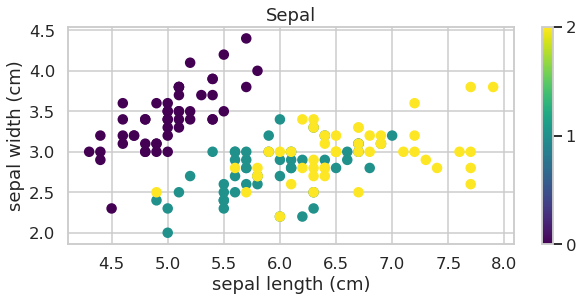

In [4]:
Show_Iris_Diagram('Sepal')

### Visualização Petal

#### Ps: Cada cor representa uma classe. Versicolor, Setosa e Virginica respectivamente

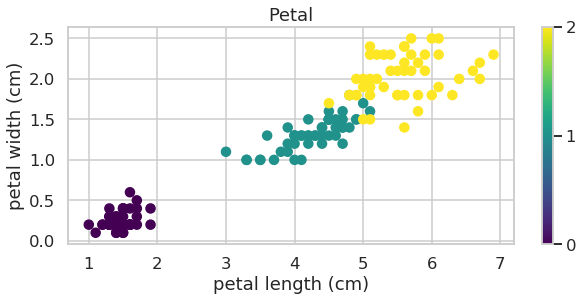

In [5]:
Show_Iris_Diagram('Petal')
#%qtconsole

## 1.2 Separação conjunto de dados

A seguir separaremos os dados em $\frac{2}{3} \approx 0,67% $ para etapa de treinamento e $\frac{1}{3} \approx 0,33% $ para teste. A função `Separate_Dataset` é responsavel por essa divisão do `iris_dataset` retornando para a chamada os arrays de treinamento e teste respectivamente

In [6]:
random.seed(123)

def Separate_DataSet():
    part_A_train = iris_dataset[0:34]
    part_A_test = iris_dataset[34:50]
    part_B_train = iris_dataset[50:84]
    part_B_test = iris_dataset[84:100]
    part_C_train = iris_dataset[100:134]
    part_C_test = iris_dataset[134:150]
    train = np.concatenate((part_A_train,
                            part_B_train,
                            part_C_train))
    test =  np.concatenate((part_A_test,
                            part_B_test,
                            part_C_test))
    return [train, test]

In [7]:
iris_dataset = np.column_stack((iris_data.data,
                                iris_data.target.T)) 
iris_dataset = list(iris_dataset)
random.shuffle(iris_dataset)


file_train, file_test = Separate_DataSet()
X = np.concatenate([file_train[:, :4], file_test[:, :4]], axis=0)
y = np.concatenate([file_train[:,4], file_test[:,4]], axis=0)


train_X = np.array([i[:4] for i in file_train])
train_y = np.array([i[4] for i in file_train])
test_X = np.array([i[:4] for i in file_test])
test_y = np.array([i[4] for i in file_test])

## 1.3 Implementação

### 1.3.1 Função ativação

A função de ativação é responsável em retornar a saída do neurônio para os sinais recebidos. Neste projeto será usada a função sigmoid, definida abaixo. 

$$g(z) = \frac{1}{1+e^{-z}}$$.

Esta função é inspirada no comportamento biológico do cérebro humano e retorna um valor real entre 0 e 1. Quanto mais próximo o valor for de 1 maior a certeza de acerto do neurônio segundo os seus pesos sinápticos.

In [8]:
def sigmoid(z):
    # convert input to a numpy array
    z = np.array(z)
    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))
    # =============================================================
    return g

### 1.3.2 Função de custo e gradiente

A função de custo regularizada mensura a performance do modelo para um conjunto de dados. A função quantifica o erro entre a previsão e o esperado. O objetivo para nossos classificadores é de encontrar um conjunto de paramêtros (pesos) que minimize essa função dada.

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Para a atualização dos pesos usaremos o `gradient descent` 

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>


In [9]:
def costFunctionReg(theta, X, y, lambda_):
     #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
        
    grad = np.zeros(theta.shape)
    
    H = sigmoid(np.dot(X, theta))
    
    Reg = (lambda_ / (2 * m)) * np.dot(theta[1:].T, theta[1:])
    J = 1 / m * (np.dot((-1 * y), np.log(H)) - np.dot((1 - y),np.log(1 - H))) + Reg 
    
    grad = 1 / m * (np.dot((H - y), X))
    grad[1:] += lambda_ / m * theta[1:]
    # =============================================================
    return J, grad

### 1.3.3 Otimização de pesos($\theta$)

Definida a função `costFunctionReg` que calcula o custo e gradiente do conjunto de dados utilizaremos a função `optimize` da library `scipy` para encontrar os valores de theta que otimizam o classificador. A função `oneVsAll` retornará os valores de $\theta$ para cada um dos classificadores. 

Utilizaremos as classes Versicolor e Virginica para o treinamento dos classificadores. O primeiro classificador estimará a chance de dada uma entrada ser Versicolor e o segundo estimará a chance de ser Virginica. Por exclusão a classe Setosa será prevista caso as duas primeiras não atinjam um critério minímo. Tal escolha foi tomada a partir da análise dos gráficos.

O lambda utilizado é `0.3` para o primeiro modelo e `0.2` para o segundo

In [10]:
def oneVsAll_2(X, y, lambda_, epochs=25, num_labels=2):
    # Some useful variables
    m, n = X.shape
    classf = [0 , 2] # Classifier to class 0 and 2
    
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    initial_theta = np.zeros(n + 1)
    options = {'maxiter': epochs}
    
    for i, c in enumerate(classf):
        all_theta[i] = optimize.minimize(costFunctionReg, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options).x
    # ============================================================
    return all_theta

In [11]:
def oneVsAll(X, y, lambda_, epochs=35, num_labels=3):
    # Some useful variables
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    initial_theta = np.zeros(n + 1)
    options = {'maxiter': epochs}
    
    for i in range(num_labels):
        all_theta[i] = optimize.minimize(costFunctionReg, 
                                initial_theta, 
                                (X, (y == i), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options).x
    # ============================================================
    return all_theta

## 1.3.4 Predição

Definida as funções `oneVsAll` e `oneVsAll_2` que treina os dois classificadores para cada tarefa. Falta implementar a função que retorna um conjunto de resposta dado um vetor de entrada `X` e os Thetas já otimizados.

As funções `predict` e `predict_2` recebem uma matriz `all_theta` e um vetor de entrada `x` e retornam a predição.

Como utilizamos apenas 2 classificadores para o primeiro modelo a classe intermediária será dada caso ambos classificadores tiverem uma certeza menor de 55%.

Já para o segundo modelo a previsão será dada pelo classificador que tiver maior saída.

In [12]:
def predict_2(all_theta, X):
    m = X.shape[0];
    num_labels = all_theta.shape[0]
    
    p = np.zeros(m)
    Prediction = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    p = sigmoid(np.dot(X, all_theta.T))
    
    for i, predict in enumerate(p):        
        maxInd = np.argmax(predict)
        if predict[maxInd] < 0.55: #If highest certainty is lower than 55% then prediction will be for class 1
            p[i] = 1
        else:       
            p[i] = maxInd + (maxInd * 1)
    # ============================================================
    return p[:,0]

In [13]:
def predict(all_theta, X):
    m = X.shape[0];
    num_labels = all_theta.shape[0]
    
    p = np.zeros(m)
    Prediction = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    p = np.argmax(sigmoid(np.dot(X, all_theta.T)), axis=1)
    # ============================================================
    return p

**Treinando e gerando previsão**

In [14]:
lambda_ = [0.3, 0.2]
trainingF = [oneVsAll_2, oneVsAll]
training_validate = [predict_2, predict]
pred = []
predCount = [[0,0,0], [0,0,0]]

for i, train in enumerate(trainingF): 
    all_theta = train(train_X, train_y, lambda_[i], 25) #generate Thetas from training group
    pred.append(training_validate[i](all_theta, test_X)) #Validade on test group
    for j in range(3):
        predCount[i][j] = pred[i] == i    

## 1.4 Perfomance classificadores

Realizada a previção armazenada na variável `pred`, veremos como foi o desempenho dos algoritmos sobre o mesmo grupo de validação.

Utlizaremos a seguinte notação para as fórmulas:
- **VP**, para Verdadeiro Positivo

- **FN**, para Falso Negativo

- **FP**, para Falso Positivo

- **VN**, Verdadeiro NEgativo

- **T**,  Total

### Acurácia

Acuracia = $\frac{VP + VN}{T}$

A ácuracia mede a frequência de acerto do modelo

```python
print('Acurácia classificador: {:.2f}%'.format(np.mean(pred[i] == test_y) * 100))
```
Acurácia: 100.00%

In [15]:
print('Acurácia classificador 1: {:.2f}%'.format(np.mean(pred[0] == test_y) * 100))
print('Acurácia classificador 2: {:.2f}%'.format(np.mean(pred[1] == test_y) * 100))

Acurácia classificador 1: 100.00%
Acurácia classificador 2: 95.83%


## Precisão

Precisão = $\frac{VP}{VP + FP}$

A precisão mede a frequência de acerto dos verdadeiros do classificador, em outras palavras a porcentagem de um verdadeiro estar certo considerando todos os ja ditos.

In [16]:
labels = ['Versicolor', 'Setosa', 'Virginica']

for classf in range(2):
    print("Classificador {}:".format(classf + 1))
    for i, label in enumerate(labels):
        true_positive = pred[classf] == i
        presicion = np.mean(true_positive == (i == test_y)) * 100
        print('Precisão classe {}: {:.2f}%'.format(label, presicion))
    print("\n")
    

Classificador 1:
Precisão classe Versicolor: 100.00%
Precisão classe Setosa: 100.00%
Precisão classe Virginica: 100.00%


Classificador 2:
Precisão classe Versicolor: 100.00%
Precisão classe Setosa: 95.83%
Precisão classe Virginica: 95.83%




## Considerações modelo

Para a validação o primeiro modelo acertou 100% das entradas. Realizado alguns testes com diferentes lambdas, e epochs a acurácia se manteve maior que 97,5%.

Para os 100 inputs de entrada um valor ótimo de epochs foi de 25. Para valores maiores começava a dar sinais de overfitting.

Como o modelo acertou todos os modelos acredita-se que ele foi capaz de fazer uma generalização ótima do problema. Não sendo necessário outros métodos mais sofisticados e que necessitem de um processamento maior como é o caso do Multilayer Perceptron.

Já o segundo modelo obteve um resultado inferior ao primeiro. Embora fosse esperado uma melhor performance com o incremento de um novo classificador, na prática isso não aconteceu. Isso aconteceu pois a classe `Setosa` e `Virginica` são muito próximas como visto nos gráficos e o classificador adicional não foi capaz de realizar uma generalização.

Como o primeiro modelo utilizou as classes `Versicolor` e `Virginica` ele conseguiu generalizar bem a classe `Versicolor` e a `Setosa` que se confundia com `Virginica` foi contornada exigindo um valor mínimo de 0.55 para a ativação dos neurônios.

Já no segundo modelo o que aconteceu foi que o classificador para `Setosa` entrava em conflito com o da `Virginica` resultando em uma pior previsão para ambas as classes.

## 2 Conjunto de dados `MNSIST`

Nesta segunda parte serão usados dois classificadores para a predição do conjunto de dados e ao final serão feitas comparações entre cada um dos classificadores.

O primeiro classificador será implementado usando um multiclassificador one-vs-all de regressão logística. O tópico `2.3` será dedicado a sua implementação e explicação do modelo.

O segundo classificador será implementado utilizando uma rede neural MPL implementado no tópico `2.5`

In [17]:
# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'MNSIST.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

## 2.0 Descrição dos dados

O conjunto de dados possui 5000 exemplos de digitos desenhados a mão, isso é um subset do conjunto original [MNIST](http://yann.lecun.com/exdb/mnist) que possui desenhos de milhares de exemplos. Este conjunto de dados esta no formato `.mat`. Para carregarmos os dados utilizaremos a libray `scipy.io`.

Cada exemplo de treinamento é um vetor de tamanho 400 e representa uma imagem 20 x 20 pixel em tons de cinza.

## 2.1 Visualização dos dados

Antes de implementar os algoritmos de aprendizado é importante visualizar os dados. A visualização pode auxiliar na escolha do algoritmo de aprendizado.

Para plotar um conjunto de exemplos segue o exemplo:

```python
   utils.displayData(X[:])
```


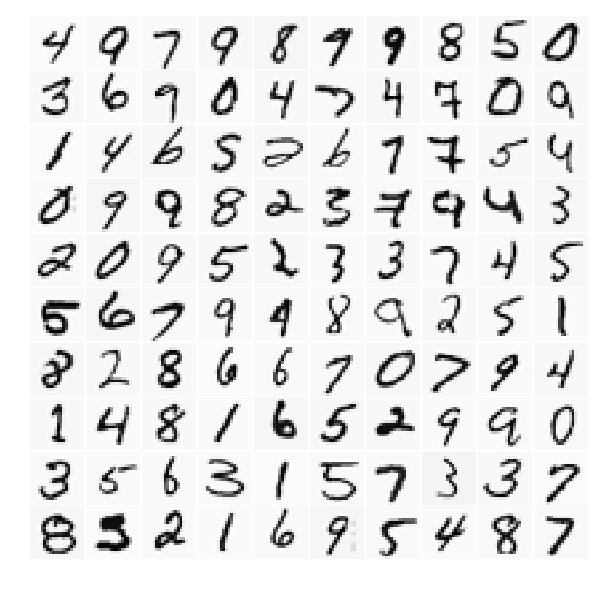

In [18]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

#Display a 100 data points
utils.displayData(sel)

## 2.2 Separação conjunto de dados

A seguir separaremos os dados em  $\frac{2}{3}$≈0,67  para etapa de treinamento e  $\frac{1}{3}$≈0,33  para teste. A função `Separate_MNIST_Dataset` é responsavel por essa divisão retornando para a chamada os arrays de treinamento e teste respectivamente. 

Para uma melhor performance é selecionada porções de mesmo tamanho para cada classe, o array final é embaralhado para garantir que o modelo não treine apenas para uma mesma classe por muito tempo.

In [19]:
def Separate_MNIST_Dataset(X, y, num_labels):
    size = y.shape[0]    
    examples_by_label = int(size / num_labels)    
    training_size = int(examples_by_label * 2 / 3)    
    test_size = examples_by_label - training_size
    
    train, test = [],[]
    X_y = np.concatenate([X, y.reshape((y.shape[0], 1))], axis=1)
    
    initial_index = 0
    for i in range(num_labels):
        part_i_train = X_y[initial_index: (initial_index + training_size)]        
        part_i_test = X_y[(initial_index + training_size): ((initial_index + training_size) + test_size)]
        
        train.append(np.array(part_i_train))        
        test.append(np.array(part_i_test))
        
        initial_index += examples_by_label
    
    train = np.array(train).reshape((-1, X_y.shape[1]))   
    test = np.array(test).reshape((-1, X_y.shape[1]))
    
    #random.shuffle(train) Reduce perfomance for One-vs-All
        
    return [{'X': train[:, :-1], 'y': train[:, -1]}, {'X': test[:, :-1], 'y': test[:, -1]}]
        
            
[train, test] = Separate_MNIST_Dataset(X, y, 10)
train_X, train_y = train['X'], train['y']
test_X, test_y = test['X'], test['y']

## 2.3 Implementação - One-vs-All

Criaremos um classificador para cada label definido de 0 a 9, sendo a previsão decidida a partir da maior saída entre os classificadores(um valor real x: $0 < x < 1$. Função sigmoid). Cada classificador servirá para decidir se um número faz parte ou não à sua classe atribuida.
### 2.3.1 Função ativação

A função de ativação utilizada será a `sigmoid` definida e implementada na parte 1.

$$g(z) = \frac{1}{1+e^{-z}}$$.


### 2.3.2 Função de custo e gradiente

A função de custo regularizada será a mesma implementada na parte 1 `costFunctionReg`

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Para a atualização dos pesos usaremos o `gradient descent` 

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

### 2.3.3 Otimização de pesos($\theta$)

Definida a função `costFunctionReg` que calcula o custo e gradiente do conjunto de dados utilizaremos a função `optimize` da library `scipy` para encontrar os valores de theta que otimizam o classificador. A função `oneVsAll` retornará os valores de $\theta$ para cada um dos classificadores. 

O lambda utilizado para esta etapa é `0.1`

In [20]:
lambda_ = 0.1
epochs = 30
all_theta = oneVsAll(train_X, train_y, lambda_, epochs, num_labels)

## 2.4 Implementação - Rede neural MPL

Nesta segunda implementação será utilizado o algoritmo de aprendizado Multilayer Perceptron. Para as funções de ativação será utlizado novamente a função sigmoid. E ao treinamento do modelo será utilizado o algoritmo backpropagation.

Uma ilustração do modelo pode ser vista abaixo:

![Neural network](Figures/neuralnetwork.png)



### 2.4.0 Estrutura da rede

- A camada de input será composta por um vetor de 400 unidades + bias.

- A camada oculta será composta por um vetor de 25 neurônios + bias.

- A camada de saida será composta por 10 neurônios correspondentes a cada rótulo e a previsão definida a partir do neurônio com maior sinal de saída. Caso seja o primeiro neurônio 0, segundo 1 e assim por diante.

## 2.4.1 Inicialização pesos sinápticos

A escolha dos pesos iniciais pode tornar o algoritmo mais eficiente e convergir a um minimo local melhor.

Para isso utilizaremos a função `randInitializeWeights`

In [21]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = np.zeros((L_out, 1 + L_in))
    
    epsilon_init = np.sqrt(6) / np.sqrt(L_in + L_out)

    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    # ============================================================
    return W

### A seguir inicializaremos os pesos para a camada oculta e de saída

In [22]:
# Setup the parameters 
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


### 2.4.2 Feedforward e backpropagation

O feedforward é a transmissão dos dados desde a camada de input até a saída gerada pelo modelo.

O backpropagation é o caminho inverso, nesta etapa ocorre um ajuste dos pesos sinápticos para se adequar a saída esperada.

Nesta parte será criada a função `nnCostFunction` cujo objetivo é retornar o array `J`, custo, para cada input passado pelo modelo e o  `gradiente` vetorizado para correção dos pesos sinápticos. As fórmulas de custo e gradient podem ser vistas abaixo.

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^{(T)} $$

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

$\delta_k^{(l)}$ = : erro. Mede o quão responsável o neurônio foi para o erro de previsão

$ \Delta^{(l)}$ : Acumulação do gradient do layer l

$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta)$: Derivada parcial custo, objetivo é reduzir esse valor




In [23]:
def sigmoidGradient(z):    
    return sigmoid(z)*(1 - sigmoid(z))

In [24]:
def nnCostFunction(nn_params, 
                   input_layer_size, 
                   hidden_layer_size, 
                   num_labels, 
                   X, y, lambda_=0.0):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
     # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    theta1, theta2 = Theta1, Theta2
    y_matrix = np.zeros((m, num_labels))
    for i, val in enumerate(y):
        y_matrix[i][val] = 1
        
    # Cost
    a1 = np.concatenate([np.ones((m,1)), X],axis=1) # 5000x401
    
    z2 = theta1.dot(a1.T) # 25x401 * 401x5000 = 25x5000 
    a2 = np.c_[np.ones((X.shape[0],1)),sigmoid(z2.T)] # 5000x26 
    
    z3 = theta2.dot(a2.T) # 10x26 * 26x5000 = 10x5000 
    a3 = sigmoid(z3) # 10x5000    
    reg = (lambda_ / (2 * m)) * (np.sum( np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])) )
    J = (-1 / m) * np.sum( (np.log(a3.T) * (y_matrix) + np.log(1 - a3).T * (1 - y_matrix)) ) + reg

    # Gradients
    d3 = a3.T - y_matrix # 5000x10
    d2 = theta2[:,1:].T.dot(d3.T)*sigmoidGradient(z2) # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    theta1_ = np.c_[np.zeros((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.zeros((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = delta1/m + theta1_*(lambda_ / m)
    theta2_grad = delta2/m + theta2_*(lambda_ / m)
    
    grad = np.concatenate([theta1_grad.ravel(), theta2_grad.ravel()])
    
    return(J, grad)

### 2.4.3 Otimização dos pesos

Definida a função `nnCostFunction` será utilizado `scipy.optimize.minimize` para treinar o a rede neural e obter um conjunto de thetas que otimizem o modelo.

In [25]:
options= {'maxiter': 100}

lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

## 2.5 Predição

Treinados os modelos falta validá-los e comparar seus desempenhos.

In [26]:
def predict_neural(Theta1, Theta2, X):
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
        
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

In [27]:
print("Validating model...")
clf_n = 2
predCount = np.zeros((clf_n,num_labels, pred.__len__()))

pred = [predict(all_theta, test_X), predict_neural(Theta1, Theta2, test_X)]

for p in range(clf_n):
    for i in range(num_labels):
        predCount[p][i] = pred == i

Validating model...


## 2.4 Perfomance classificadores

Realizada a predição armazenada na variável `pred`, veremos como foi o desempenho do algoritmo de aprendizado sobre o grupo de validação.

Utlizaremos a seguinte notação para as fórmulas:
- **VP**, para Verdadeiro Positivo

- **FN**, para Falso Negativo

- **FP**, para Falso Positivo

- **VN**, Verdadeiro NEgativo

- **T**,  Total

### Acurácia

Acuracia = $\frac{VP + VN}{T}$

A ácuracia mede a frequência de acerto do modelo

```python
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == test_y) * 100))
```
Acurácia: 100.00%

In [28]:
clf_name = ["OneVsAll", "MPL"]
for p in range(clf_n):
    print('Acurácia classificador {}: {:.2f}%'.format(clf_name[p], np.mean(pred[p] == test_y) * 100))

Acurácia classificador OneVsAll: 89.70%
Acurácia classificador MPL: 95.57%


## Precisão

Precisão = $\frac{VP}{VP + FP}$

A precisão mede a frequência de acerto dos verdadeiros do classificador, em outras palavras a porcentagem de um verdadeiro estar certo levando em conta todos os ja ditos.

In [29]:
labels = np.arange(0,10)
presicion = {0:[],1:[]}

for p in range(clf_n):
    print("Classificador: {}".format(clf_name[p]))
    for i, label in enumerate(labels):
        true_positive = pred[p] == i
        presicion[p].append(np.mean(true_positive == (i == test_y)) * 100)
        print('Precisão classe {}: {:.2f}%'.format(label, presicion[p][i]))
    print("\n")
    
print("Diferença de precisão por label. (MPL - OneVsAll)")
for i, label in enumerate(labels):
    true_positive = pred[p] == i
    print( 'classe {}: {:.2f}%'.format(label, presicion[1][i] - presicion[0][i]) )
    

Classificador: OneVsAll
Precisão classe 0: 99.04%
Precisão classe 1: 99.40%
Precisão classe 2: 97.43%
Precisão classe 3: 97.66%
Precisão classe 4: 97.90%
Precisão classe 5: 96.29%
Precisão classe 6: 98.44%
Precisão classe 7: 98.56%
Precisão classe 8: 97.54%
Precisão classe 9: 97.13%


Classificador: MPL
Precisão classe 0: 99.52%
Precisão classe 1: 99.46%
Precisão classe 2: 98.92%
Precisão classe 3: 98.86%
Precisão classe 4: 99.22%
Precisão classe 5: 98.80%
Precisão classe 6: 99.22%
Precisão classe 7: 99.16%
Precisão classe 8: 99.16%
Precisão classe 9: 98.80%


Diferença de precisão por label. (MPL - OneVsAll)
classe 0: 0.48%
classe 1: 0.06%
classe 2: 1.50%
classe 3: 1.20%
classe 4: 1.32%
classe 5: 2.51%
classe 6: 0.78%
classe 7: 0.60%
classe 8: 1.62%
classe 9: 1.68%


### Para ver a previsão para saídas reais utilize o trecho de código abaixo

Neural Network Prediction: 6


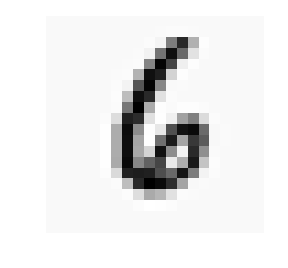

In [30]:
# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict_neural(Theta1, Theta2, X[i])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

## Considerações finais

Podemos observar que a rede neural MPL ofereceu um ganho significativo. Isto ocorre pois o incremento de neurônios permite uma maior diversidade e flexibilidade das funções geradas, oferecendo um melhor mapeamento de características dos dados análisados.

Cada camada de neurônios gera um padrão de ativação que possibilita um melhor reconhecimento das características que definem cada classe.

### Visualização camada oculta

Uma forma de entender o que uma rede neural está aprendendo é visualizar quais representações estão sendo capturados pelas unidades ocultas. Informalmente, dada uma unidade oculta, uma forma de visualizar o que está sendo computado é encontrar um input x que causará sua ativação(valor proximo de 1). Para a rede neural treinada a $i^{th}$ linha de $\Theta^{(1)}$ é um vetor de dimensão 401. Se descartarmos o bias temos um vetor de tamanho 400 que representa os pesos para cada pixel de input.

Dessa forma uma forma de visualizar a "representaçãO" captudara pela unidade oculta é de redimensionar esse vetor em uma imagem 20 x 20, isto é equivalente a encontrar o input que dá a maior ativação para unidade oculta.

Utilizaremos a função `displayData` para mostrar a imagem de cada unidade oculta.

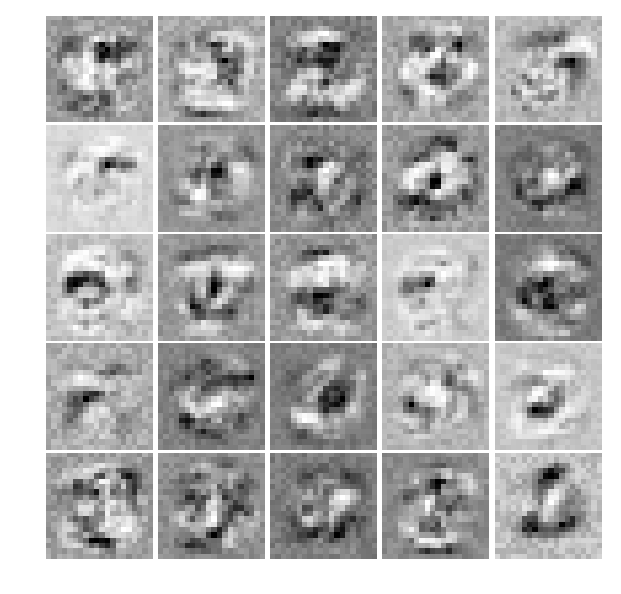

In [31]:
utils.displayData(Theta1[:, 1:])